<a href="https://colab.research.google.com/github/Suffergate/Stack/blob/main/BIT_GeoAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remote Sensing Image Change Detection

In [8]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import requests
import zipfile
import io

# Mount Google Drive
from google.colab import drive

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## ResNet18 S5 Backbone + Prediction Head

In [9]:
class ResNetBackbone(nn.Module):
    """Modified ResNet18 backbone for feature extraction"""
    def __init__(self, output_channels=32, backbone='resnet18'):
        super(ResNetBackbone, self).__init__()

        # Load pre-trained ResNet
        if backbone == 'resnet18':
            self.resnet = models.resnet18(pretrained=True)
        else:
            raise NotImplementedError('Only ResNet18 is supported now')

        # Whether to upsample by 2x at the end
        self.if_upsample_2x = True

        # Pointwise convolution to reduce channel dimension
        self.conv_pred = nn.Conv2d(512, output_channels, kernel_size=3, padding=1)

        # Replace stride in last two layers to preserve spatial resolution
        for layer in [self.resnet.layer3, self.resnet.layer4]:
            for module in layer.modules():
                if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                    module.stride = (1, 1)

    def forward(self, x):
        # Input size for reference
        input_size = x.shape[2:]

        # ResNet layers
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x_4 = self.resnet.layer1(x)     # 1/4, 64 channels
        x_8 = self.resnet.layer2(x_4)   # 1/8, 128 channels
        x_16 = self.resnet.layer3(x_8)  # 1/8, 256 channels (stride modified)
        x_32 = self.resnet.layer4(x_16) # 1/8, 512 channels (stride modified)

        # Upsample if needed (to 1/4)
        if self.if_upsample_2x:
            x = F.interpolate(x_32, scale_factor=2, mode='bilinear', align_corners=True)
        else:
            x = x_32

        # Output convolution to reduce channels
        x = self.conv_pred(x)

        return x

In [10]:
class TwoLayerConv2d(nn.Sequential):
    """Two-layer convolutional module used in the prediction head"""
    def __init__(self, in_channels, out_channels):
        super(TwoLayerConv2d, self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        )

## Base Model Implementation

In [11]:
class BaseChangeDetectionModel(nn.Module):
    """
    Base model for change detection consisting of:
    1. ResNet18 backbone
    2. Feature differencing
    3. Prediction head
    """
    def __init__(self, num_classes=2, output_channels=32):
        super(BaseChangeDetectionModel, self).__init__()

        # ResNet18 backbone
        self.backbone = ResNetBackbone(output_channels=output_channels)

        # Prediction head - a small CNN for change discrimination
        self.classifier = TwoLayerConv2d(output_channels, num_classes)

        # Whether to upsample by 2x in the backbone
        self.if_upsample_2x = True

        # Whether to apply sigmoid at output
        self.output_sigmoid = False
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        """
        Args:
            x1: Image at time 1 (B, C, H, W)
            x2: Image at time 2 (B, C, H, W)

        Returns:
            change_pred: Change prediction (B, num_classes, H, W)
        """
        # Extract features from both temporal images
        feat1 = self.forward_single(x1)
        feat2 = self.forward_single(x2)

        # Feature differencing
        diff = torch.abs(feat1 - feat2)

        # Final upsampling to original resolution
        if not self.if_upsample_2x:
            diff = F.interpolate(diff, scale_factor=2, mode='bilinear', align_corners=True)

        diff = F.interpolate(diff, scale_factor=4, mode='bilinear', align_corners=True)

        # Classification head
        change_pred = self.classifier(diff)

        # Apply sigmoid if needed (for binary case)
        if self.output_sigmoid:
            change_pred = self.sigmoid(change_pred)

        # Ensure output size matches the input size
        original_size = x1.shape[2:]
        if change_pred.shape[2:] != original_size:
            change_pred = F.interpolate(change_pred, size=original_size, mode='bilinear', align_corners=True)

        return change_pred

    def forward_single(self, x):
        """Forward pass for a single temporal image"""
        return self.backbone(x)

## Data loading


In [12]:
# Dataset for change detection
class ChangeDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', img_size=256, transform=None):
        """
        Args:
            root_dir: Root directory of the dataset
            split: 'train', 'val', or 'test'
            img_size: Size to resize images to
            transform: Optional transform to apply to the images
        """
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        self.transform = transform

        # Define directories
        self.img_dir_A = os.path.join(root_dir, 'A')  # Images from time 1
        self.img_dir_B = os.path.join(root_dir, 'B')  # Images from time 2
        self.label_dir = os.path.join(root_dir, 'label')  # Change masks

        # Read the list file to get image names
        list_file = os.path.join(root_dir, 'list', f'{split}.txt')
        with open(list_file, 'r') as f:
            self.img_names = [line.strip() for line in f.readlines()]

        print(f"Loaded {len(self.img_names)} images for {split}")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]

        # Load images and label
        img_A_path = os.path.join(self.img_dir_A, img_name)
        img_B_path = os.path.join(self.img_dir_B, img_name)
        label_path = os.path.join(self.label_dir, img_name)

        img_A = Image.open(img_A_path).convert('RGB')
        img_B = Image.open(img_B_path).convert('RGB')
        label = Image.open(label_path).convert('L')  # Grayscale

        # Resize images
        if img_A.size[0] != self.img_size or img_A.size[1] != self.img_size:
            img_A = img_A.resize((self.img_size, self.img_size), Image.BILINEAR)
            img_B = img_B.resize((self.img_size, self.img_size), Image.BILINEAR)
            label = label.resize((self.img_size, self.img_size), Image.NEAREST)

        # Convert to numpy arrays
        img_A = np.array(img_A)
        img_B = np.array(img_B)
        label = np.array(label)

        # Normalize label to 0/1
        label = label // 255

        # Apply transforms if specified
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        else:
            # Default normalization
            img_A = img_A.transpose(2, 0, 1).astype(np.float32) / 255.0
            img_B = img_B.transpose(2, 0, 1).astype(np.float32) / 255.0

            # Normalize with ImageNet mean and std
            mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
            std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
            img_A = (img_A - mean) / std
            img_B = (img_B - mean) / std

            # Convert to tensor with explicit float32 type
            img_A = torch.from_numpy(img_A).float()
            img_B = torch.from_numpy(img_B).float()

        # Convert label to tensor
        label = torch.from_numpy(label).long().unsqueeze(0)

        return {
            'A': img_A,
            'B': img_B,
            'L': label,
            'name': img_name
        }

In [13]:
def download_sample_dataset():
    # Check if the data is already downloaded
    if os.path.exists('samples/A') and os.path.exists('samples/B') and os.path.exists('samples/label'):
        print("Sample dataset already exists.")
        return

    # Create directories
    os.makedirs('samples/A', exist_ok=True)
    os.makedirs('samples/B', exist_ok=True)
    os.makedirs('samples/label', exist_ok=True)
    os.makedirs('samples/list', exist_ok=True)

    print("Creating a toy dataset for demonstration...")

    # Create sample list files
    with open('samples/list/train.txt', 'w') as f:
        f.write("sample1.png\nsample2.png\n")

    with open('samples/list/val.txt', 'w') as f:
        f.write("sample3.png\n")

    # Create synthetic images with changes
    for i, name in enumerate(['sample1.png', 'sample2.png', 'sample3.png']):
        # Base image (random noise)
        np.random.seed(i)
        img_base = np.random.randint(100, 200, (256, 256, 3), dtype=np.uint8)

        # Create time 1 image - add some structures
        img_A = img_base.copy()

        # Add rectangles of different colors at different positions
        for j in range(3):
            x1, y1 = np.random.randint(50, 150, 2)
            x2, y2 = x1 + np.random.randint(30, 80), y1 + np.random.randint(30, 80)
            color = np.random.randint(0, 255, 3)
            img_A[y1:y2, x1:x2] = color

        # Create time 2 image - keep some structures, change others
        img_B = img_base.copy()

        # Add the same rectangles but change some of them
        change_mask = np.zeros((256, 256), dtype=np.uint8)

        for j in range(3):
            x1, y1 = np.random.randint(50, 150, 2)
            x2, y2 = x1 + np.random.randint(30, 80), y1 + np.random.randint(30, 80)
            color = np.random.randint(0, 255, 3)
            img_B[y1:y2, x1:x2] = color

            # Mark some rectangles as changed
            if j % 2 == 0:
                change_mask[y1:y2, x1:x2] = 255

        # Save images
        Image.fromarray(img_A).save(f'samples/A/{name}')
        Image.fromarray(img_B).save(f'samples/B/{name}')
        Image.fromarray(change_mask).save(f'samples/label/{name}')

    print("Toy dataset created with synthetic changes.")

In [14]:
def setup_levir_dataset(drive_path, save_dir='LEVIR-s2looking10_dataset'):
    """
    Set up the dataset using files from Google Drive

    Args:
        drive_path: Path to the folder on Google Drive containing A, B, and label folders
        save_dir: Local directory to save the dataset structure
    """
    import shutil

    # Create local directories
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'list'), exist_ok=True)

    # Check if the source directories exist
    a_dir = os.path.join(drive_path, 'A')
    b_dir = os.path.join(drive_path, 'B')
    label_dir = os.path.join(drive_path, 'label')

    if not (os.path.exists(a_dir) and os.path.exists(b_dir) and os.path.exists(label_dir)):
        print(f"Error: Required directories not found in {drive_path}")
        print(f"Expected structure: {drive_path}/A, {drive_path}/B, {drive_path}/label")
        return None

    # Create symbolic links to avoid copying large files
    os.symlink(a_dir, os.path.join(save_dir, 'A'))
    os.symlink(b_dir, os.path.join(save_dir, 'B'))
    os.symlink(label_dir, os.path.join(save_dir, 'label'))

    # Get all image filenames
    all_files = [f for f in os.listdir(a_dir) if f.endswith('.png')]
    all_files.sort()

    print(f"Found {len(all_files)} images in the dataset")

    # Split into train/val (80/20 split)
    train_size = int(len(all_files) * 0.8)
    train_files = all_files[:train_size]
    val_files = all_files[train_size:]

    # Create list files
    with open(os.path.join(save_dir, 'list', 'train.txt'), 'w') as f:
        for filename in train_files:
            f.write(f"{filename}\n")

    with open(os.path.join(save_dir, 'list', 'val.txt'), 'w') as f:
        for filename in val_files:
            f.write(f"{filename}\n")

    print(f"Created dataset with {len(train_files)} training and {len(val_files)} validation images")
    return save_dir

## Training

In [15]:
# Training function
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(data_loader):
        # Get data
        img_A = batch['A'].to(device)
        img_B = batch['B'].to(device)
        labels = batch['L'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(img_A, img_B)

        # Compute loss
        loss = criterion(outputs, labels.squeeze(1))

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()

    return running_loss / len(data_loader)


In [16]:

# Validation function
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Get data
            img_A = batch['A'].to(device)
            img_B = batch['B'].to(device)
            labels = batch['L'].to(device)

            # Forward
            outputs = model(img_A, img_B)

            # Compute loss
            loss = criterion(outputs, labels.squeeze(1))

            # Statistics
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) * labels.size(2) * labels.size(3)
            correct += (predicted == labels.squeeze(1)).sum().item()

    val_loss = running_loss / len(data_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc


## Predictions


In [17]:

# Prediction visualization
def visualize_predictions(model, data_loader, device, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break

            # Get data
            img_A = batch['A'].to(device)
            img_B = batch['B'].to(device)
            labels = batch['L']

            # Forward
            outputs = model(img_A, img_B)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()

            # Convert images back to numpy for visualization
            img_A = img_A[0].cpu().numpy().transpose(1, 2, 0)
            img_B = img_B[0].cpu().numpy().transpose(1, 2, 0)
            label = labels[0].cpu().numpy().squeeze()

            # Denormalize images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_A = std * img_A + mean
            img_B = std * img_B + mean
            img_A = np.clip(img_A, 0, 1)
            img_B = np.clip(img_B, 0, 1)

            # Plot
            axes[i, 0].imshow(img_A)
            axes[i, 0].set_title('Image A (t1)')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(img_B)
            axes[i, 1].set_title('Image B (t2)')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(label, cmap='gray')
            axes[i, 2].set_title('Ground Truth')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(predicted[0], cmap='gray')
            axes[i, 3].set_title('Prediction')
            axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()


Found 10 images in the dataset
Created dataset with 8 training and 2 validation images
Loaded 8 images for train
Loaded 2 images for val


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


Epoch 1/10


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Train Loss: 0.7257, Val Loss: 0.6203, Val Acc: 86.34%
Epoch 2/10


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train Loss: 0.5311, Val Loss: 0.5288, Val Acc: 96.42%
Epoch 3/10


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Train Loss: 0.3831, Val Loss: 0.4717, Val Acc: 98.59%
Epoch 4/10


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Train Loss: 0.2737, Val Loss: 0.3744, Val Acc: 99.55%
Epoch 5/10


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Train Loss: 0.1955, Val Loss: 0.2518, Val Acc: 99.55%
Epoch 6/10


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Train Loss: 0.1403, Val Loss: 0.2213, Val Acc: 99.55%
Epoch 7/10


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Train Loss: 0.1046, Val Loss: 0.1418, Val Acc: 99.55%
Epoch 8/10


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Train Loss: 0.0815, Val Loss: 0.1096, Val Acc: 99.55%
Epoch 9/10


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Train Loss: 0.0635, Val Loss: 0.0788, Val Acc: 99.55%
Epoch 10/10


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

Train Loss: 0.0498, Val Loss: 0.0569, Val Acc: 99.55%


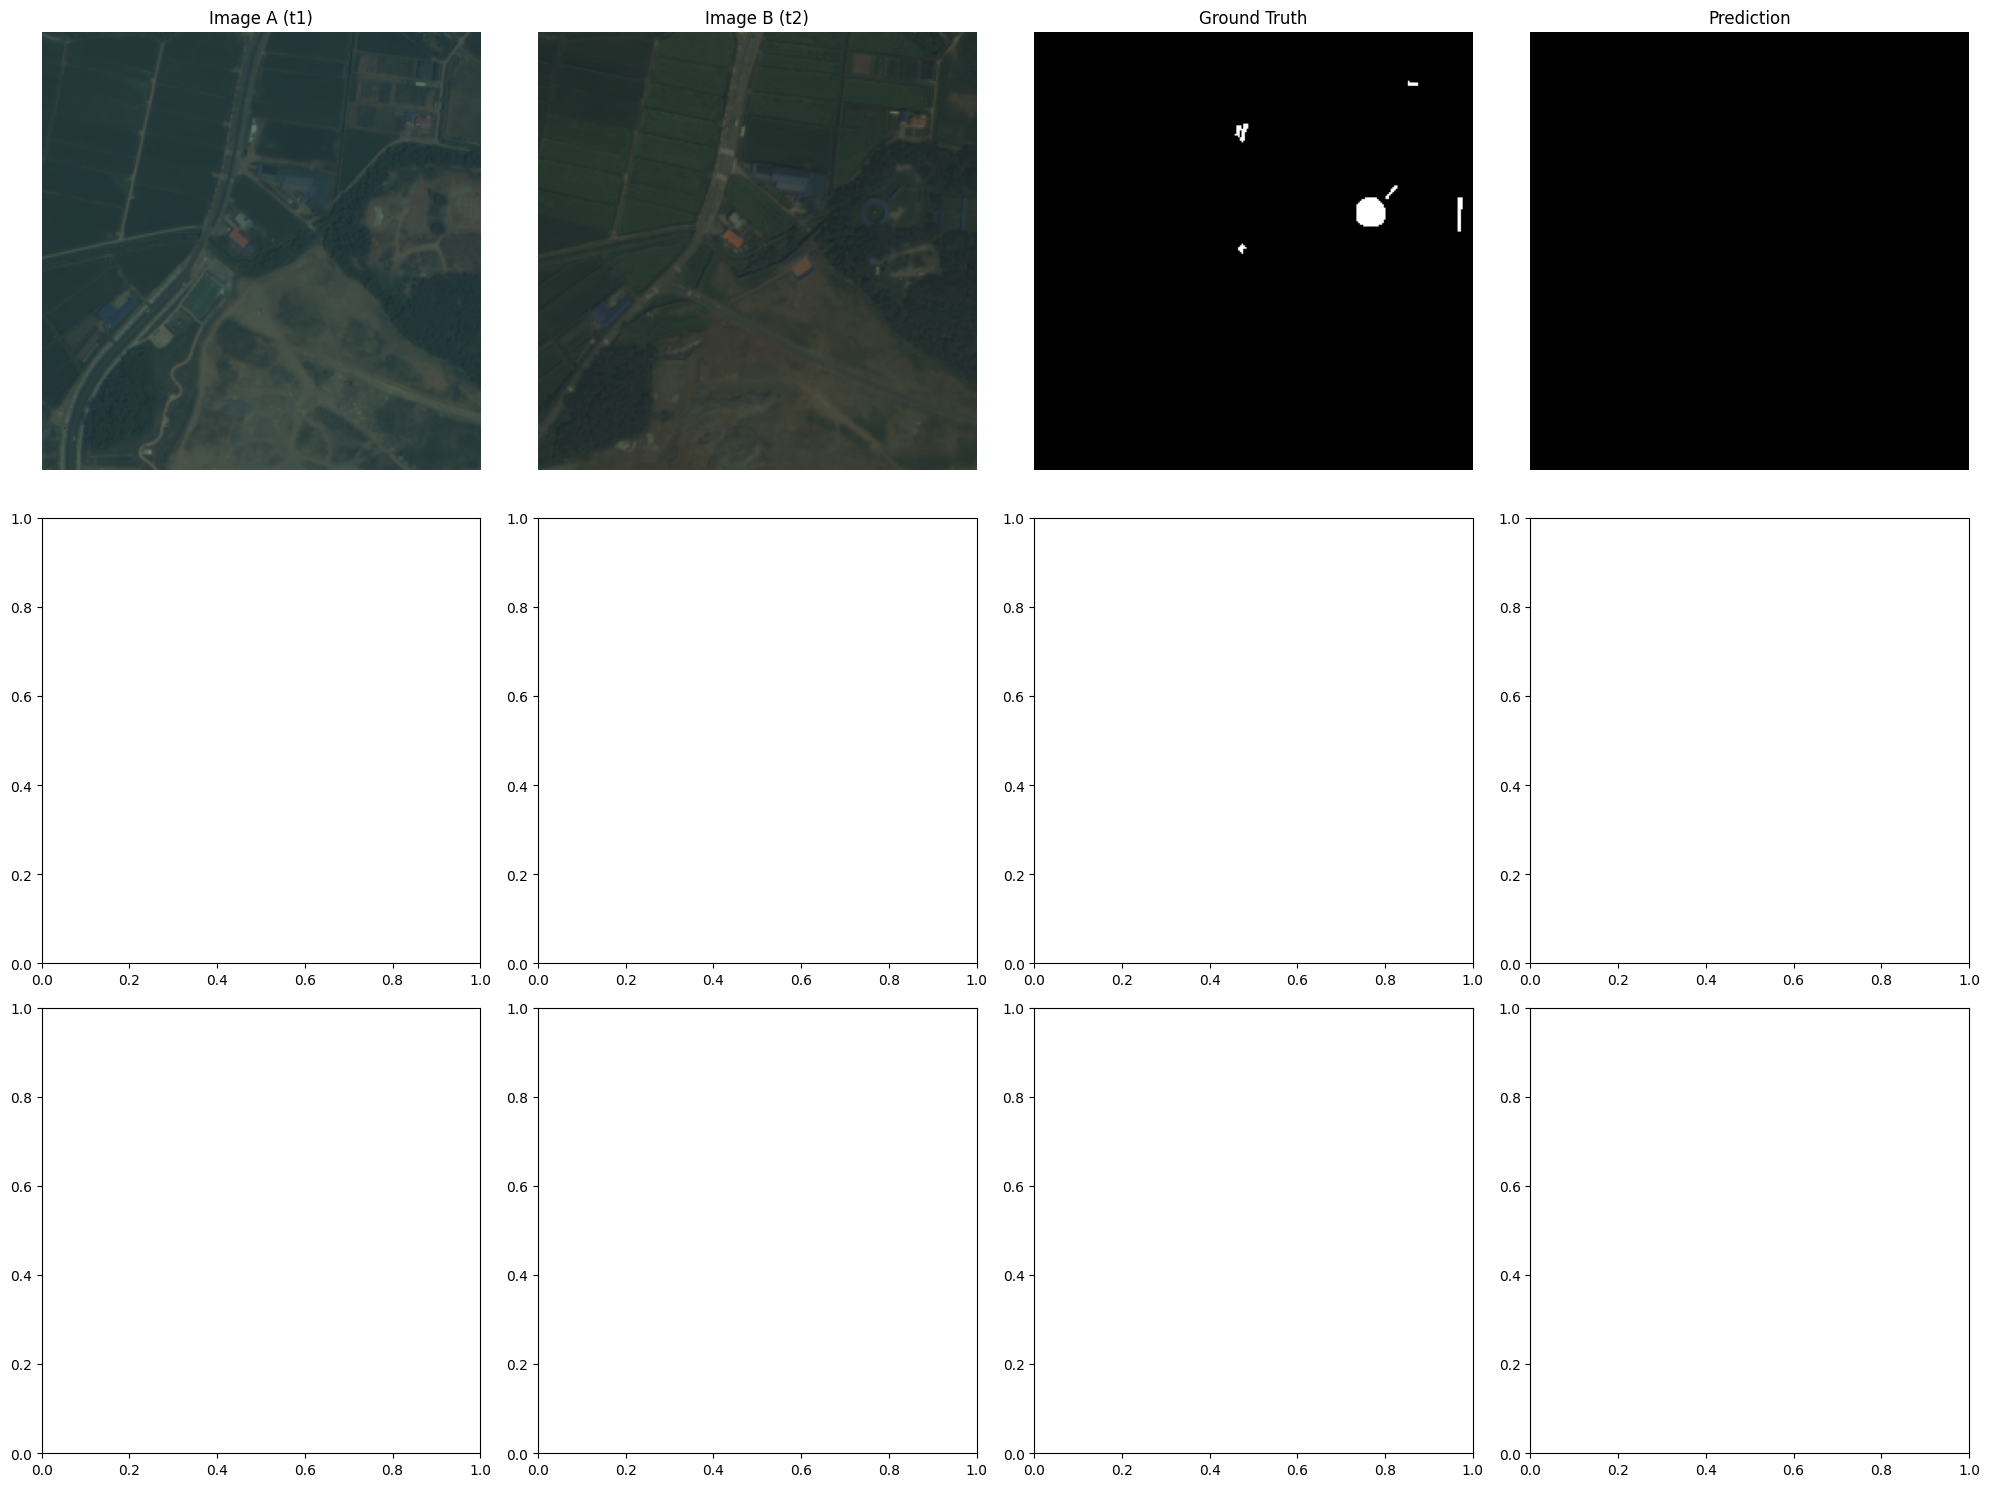

Model saved.


In [19]:
# Main function
def main():
    # Set path to your Google Drive folder containing the dataset
    # Adjust this path to match your Google Drive folder structure
    drive_path = '/content/drive/MyDrive/data/s2Looking10'


    # Set up the dataset
    dataset_dir = setup_levir_dataset(drive_path)

    if dataset_dir is None:
        print("Failed to set up dataset. Exiting.")
        return

    # Set hyperparameters
    batch_size = 4
    learning_rate = 0.001
    num_epochs = 10
    img_size = 256

    # Create datasets and dataloaders
    train_dataset = ChangeDetectionDataset(root_dir=dataset_dir, split='train', img_size=img_size)
    val_dataset = ChangeDetectionDataset(root_dir=dataset_dir, split='val', img_size=img_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Create model
    model = BaseChangeDetectionModel(num_classes=2, output_channels=32).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Visualize predictions
    visualize_predictions(model, val_loader, device)

    # Save model
    torch.save(model.state_dict(), 'base_model.pth')
    print("Model saved.")

if __name__ == '__main__':
    main()